# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import wfdb
import pandas as pd
import ast
import random

In [2]:
import data_visualisation as dv
import data_augmentation as da
from PTBXL import PTBXL
import importlib

importlib.reload(dv)
importlib.reload(da)

<module 'data_augmentation' from '/home/raaif/Desktop/Uni/y4/FYP/data_augmentation.py'>

# WFDB Library Example

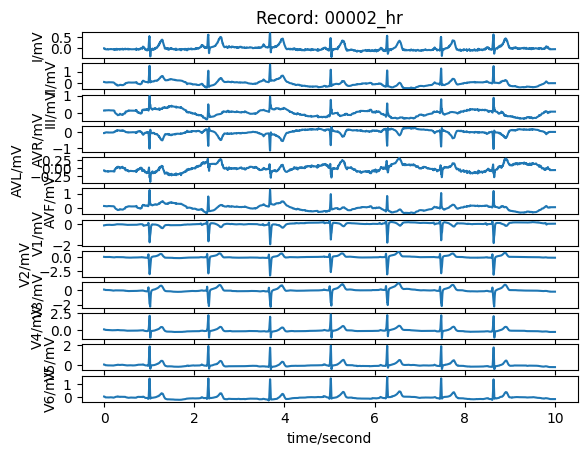

In [3]:
# load a sample ECG from a .dat file
record = wfdb.io.rdrecord('physionet.org/files/ptb-xl/1.0.3/records500/00000/00002_hr')
wfdb.plot_wfdb(record=record)

# Data load example using the WFDB library.

In [5]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
print('Loading data...')
X = load_raw_data(Y, sampling_rate, path)
print('Data loaded.')

# Load scp_statements.csv for diagnostic aggregation
print('Loading scp_statements...')
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print('Scp statements loaded.')

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

Loading data...
Data loaded.
Loading scp_statements...
Scp statements loaded.


In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# get the unique lables
print('Unique labels: ', y_train)

(19601, 1000, 12) (2198, 1000, 12) (19601,) (2198,)
Unique labels:  ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19601, dtype: object


# Loading PTBXL and China dataset

In [3]:
brugada_sample_path = "DAT China Brugada ECGs/dat/95214949528548_2015-06-19101240.dat"
brugada_sample_path2 = "DAT China Brugada ECGs/dat/95216089523481_2020-10-20144516.dat"
ptb_sample_path = "physionet.org/files/ptb-xl/1.0.3/records500/00000/00010_hr.dat"
ptb_sample_path_wfdb = ptb_sample_path.replace('.dat', '')


# load a sample ECG from a .dat file as a numpy array
f = open(brugada_sample_path2, "rb")
ecg_1 = np.fromfile(f, dtype=np.int16)
ecg_1 = np.reshape(ecg_1, (8, 5000))
ecg_1 = np.vstack([ecg_1, ecg_1[1] - ecg_1[0]]) # ecg_1_dict['III'] = ecg_1_dict['II'] - ecg_1_dict['I']
ecg_1 = np.vstack([ecg_1, -0.5 * (ecg_1[0] + ecg_1[1])]) # ecg_1_dict['aVR'] = -0.5 * (ecg_1_dict['I'] + ecg_1_dict['II'])
ecg_1 = np.vstack([ecg_1, ecg_1[0] - 0.5 * ecg_1[1]]) # ecg_1_dict['aVL'] = ecg_1_dict['I'] - 0.5 * ecg_1_dict['II']
ecg_1 = np.vstack([ecg_1, ecg_1[1] - 0.5 * ecg_1[0]]) # ecg_dict['aVF'] = ecg_dict['II'] - 0.5 * ecg_dict['I']
f.close()
print(ecg_1.shape)

f = open(ptb_sample_path, "rb")
ecg_2 = np.fromfile(f, dtype=np.int16)
ecg_2 = np.reshape(ecg_2, (5000, 12))
ecg_2 = ecg_2.transpose()
f.close()
print(ecg_2.shape)

dv.plot_12_lead_ecg(ecg_1)
dv.plot_12_lead_ecg(ecg_2)

record = wfdb.io.rdrecord(ptb_sample_path_wfdb)
wfdb.plot_wfdb(record=record)

FileNotFoundError: [Errno 2] No such file or directory: 'DAT China Brugada ECGs/dat/95216089523481_2020-10-20144516.dat'

# Custom PTBXL Dataset class

(12, 5000)


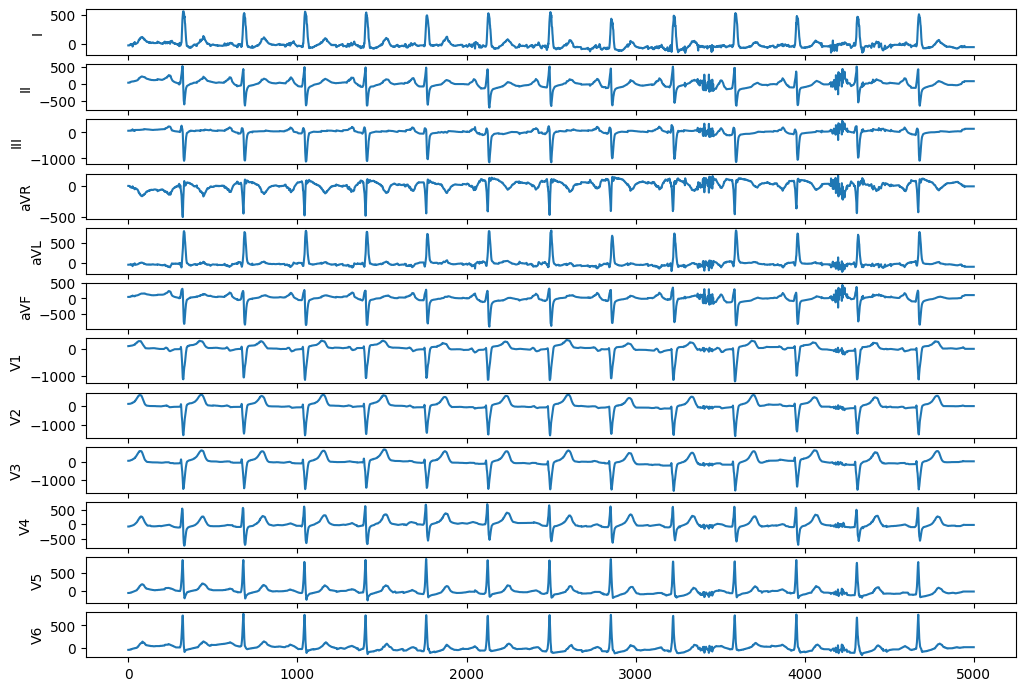

[0 1 0 1 0]
(12, 5000)


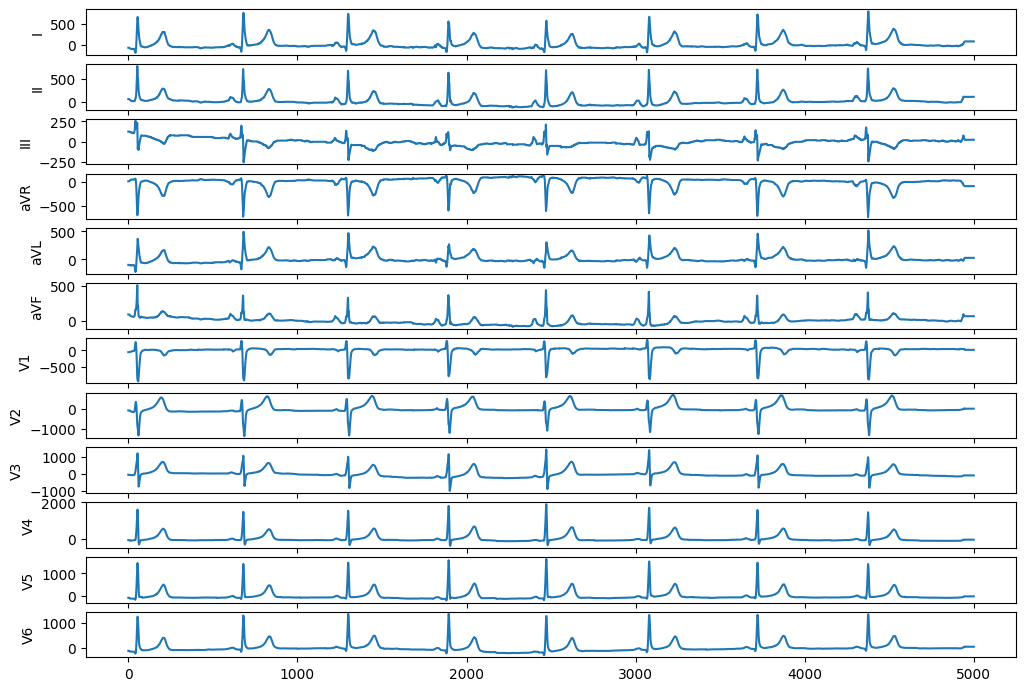

[1 0 0 0 0]


In [3]:
root_dir = 'physionet.org/files/ptb-xl/1.0.3/'
ptbxl = PTBXL(root_dir=root_dir)

# print(ptbxl.get_labels())

item, label = ptbxl[random.randint(0, len(ptbxl))]

print(item.shape)
dv.plot_12_lead_ecg(item)
print(label)

item, label = ptbxl[random.randint(0, len(ptbxl))]

print(item.shape)
dv.plot_12_lead_ecg(item)
print(label)

# Data Augmentation techniques

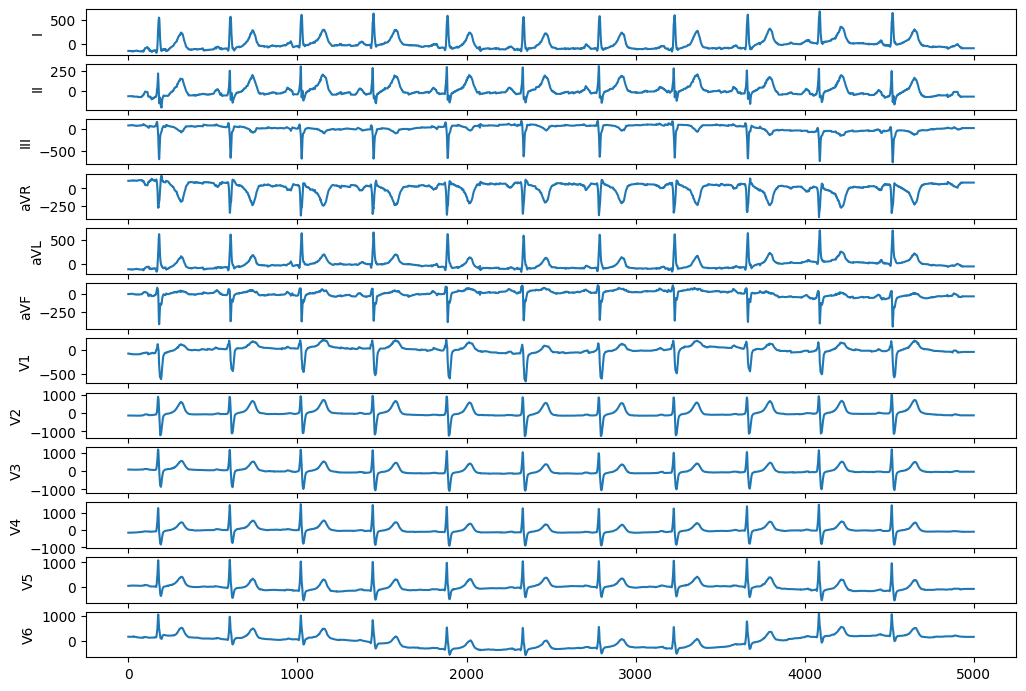

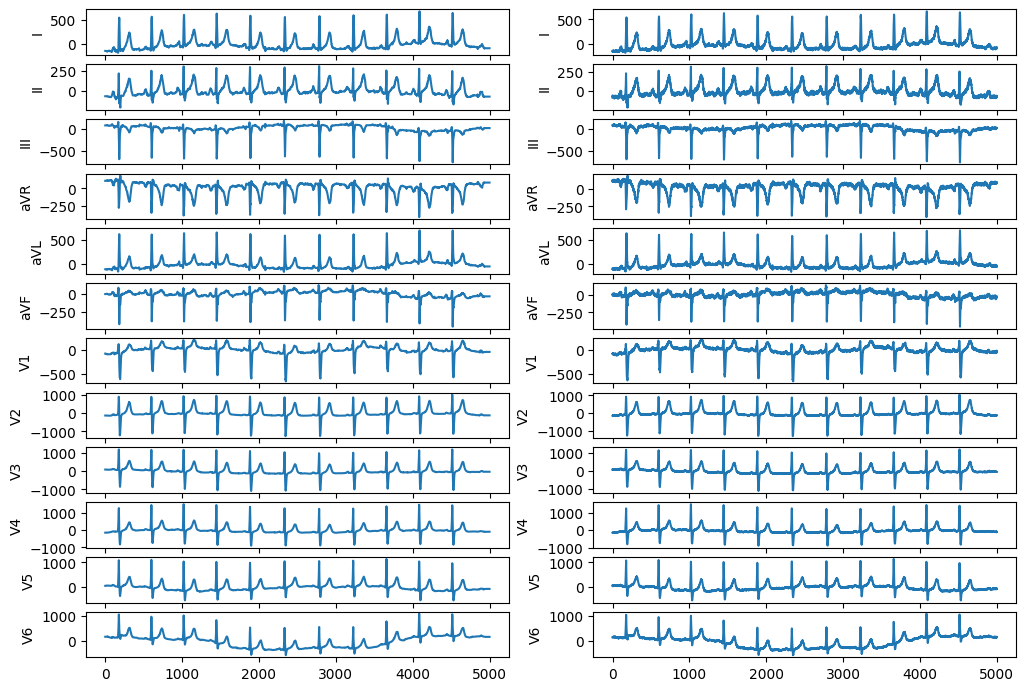

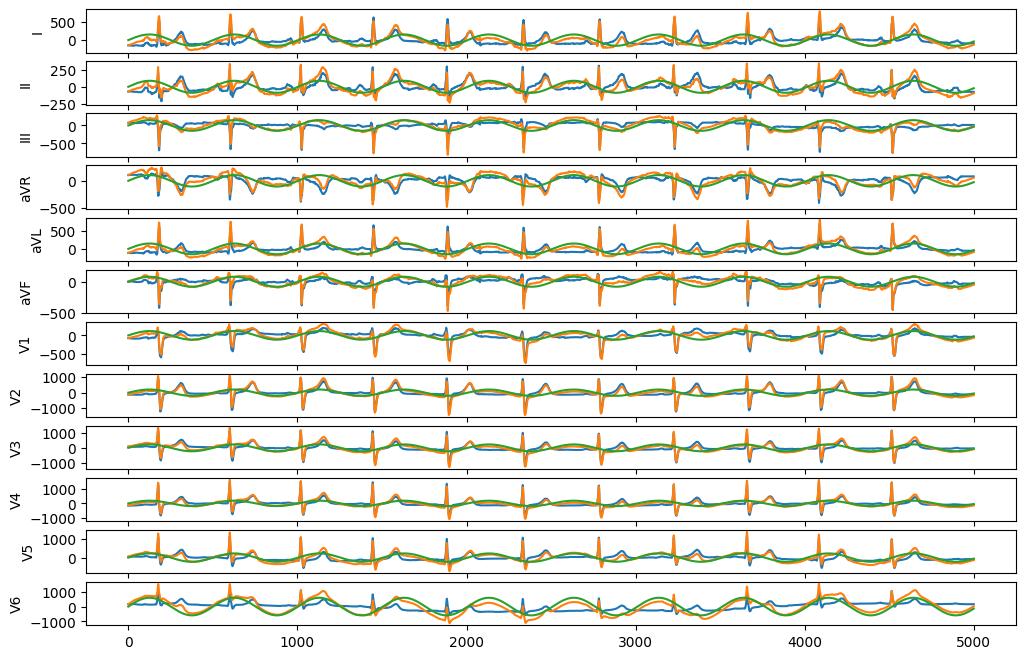

In [4]:
random_item, random_label = ptbxl[random.randint(0, len(ptbxl))]

dv.plot_12_lead_ecg(random_item)

random_noise_item = da.add_random_noise(random_item)
dv.plot_12_lead_ecgs(np.array([random_item, random_noise_item]))

drifted, drift = da.add_random_baseline_drift(random_item, strength = 0.1)
dv.plot_12_lead_ecgs_superimposed(np.array([random_item, drifted, drift]))


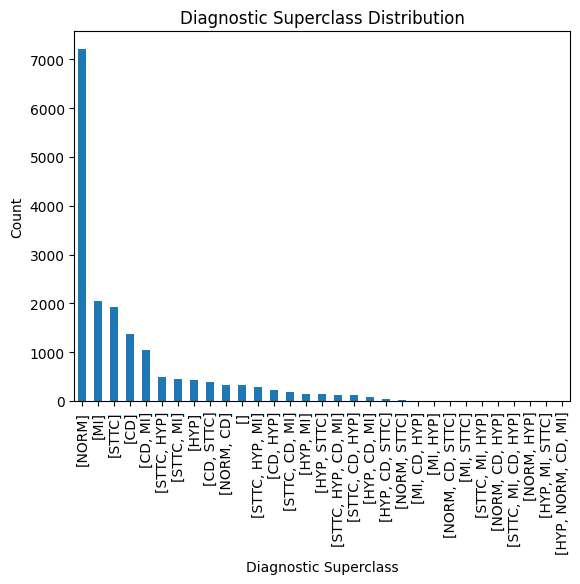

In [5]:
# get label distribution
label_distribution = ptbxl.annotations['diagnostic_superclass'].value_counts()
plot = label_distribution.plot(kind='bar')
plot.set_xlabel('Diagnostic Superclass')
plot.set_ylabel('Count')
plot.set_title('Diagnostic Superclass Distribution')
plt.show()


# Test / Train split

In [6]:
# get train and test data
from torch.utils.data import DataLoader

root_dir = 'physionet.org/files/ptb-xl/1.0.3/'
ptbxl_train = PTBXL(root_dir=root_dir, split='train', test_size=0.2, random_state=42)
ptbxl_test = PTBXL(root_dir=root_dir, split='test', test_size=0.2, random_state=42)

# check all elements are same size
print(len(ptbxl_train), len(ptbxl_test))

i = 0
for item, label in ptbxl_train:
    print(label, ptbxl_train.get_codes_from_label(label))
    i += 1
    if i > 10:
        break

# Create DataLoader instances for training and testing
train_loader = DataLoader(ptbxl_train, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(ptbxl_test, batch_size=32, shuffle=False, drop_last=True)

17439 4360
[0 1 0 1 0] ['MI', 'CD']
[0 0 1 0 1] ['STTC', 'HYP']
[1 0 0 0 0] ['NORM']
[0 1 0 1 0] ['MI', 'CD']
[0 0 1 0 0] ['STTC']
[0 0 1 0 1] ['STTC', 'HYP']
[0 0 0 1 0] ['CD']
[1 0 0 0 0] ['NORM']
[1 0 0 0 0] ['NORM']
[0 0 0 1 0] ['CD']
[0 0 1 0 1] ['STTC', 'HYP']


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class Simple1DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple1DCNN, self).__init__()
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.fc1 = nn.Linear(256 * 625, 256)  # Assuming input length is 5000
        self.fc2 = nn.Linear(256, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 12 x 5000 
        x = self.pool(self.relu(self.conv1(x)))
        # 60 x 2500
        x = self.pool(self.relu(self.conv2(x)))
        # 128 x 1250
        x = self.pool(self.relu(self.conv3(x)))
        # 256 x 625
        x = torch.flatten(x, 1)  # Flatten the tensors for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [8]:
class ECGFeatureExtractorRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False, dropout_rate=0):
        """
        Initialize the ECG RNN feature extractor.
        
        Parameters:
        - input_size (int): The number of features in the input. For ECG, this is the number of leads, so 12.
        - hidden_size (int): The number of features in the hidden state.
        - num_layers (int): Number of recurrent layers.
        - bidirectional (bool): If True, becomes a bidirectional LSTM.
        - dropout_rate (float): If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer.
        """
        super(ECGFeatureExtractorRNN, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout=dropout_rate,
                            batch_first=True)
        
        self.dropout = nn.Dropout(dropout_rate)
        
        # Adjust the size of the output features depending on whether the LSTM is bidirectional
        self.feature_size = hidden_size * 2 if bidirectional else hidden_size
        
    def forward(self, x):
        """
        Forward pass for the ECG RNN feature extractor.
        
        Parameters:
        - x (Tensor): The input tensor of shape (batch_size, sequence_length, input_size).
                      For ECG, sequence_length is 5000 and input_size is 12.
                      
        Returns:
        - features (Tensor): Extracted features of shape (batch_size, sequence_length, feature_size).
        """
        # LSTM
        x, (h_n, c_n) = self.lstm(x)
        
        # Optionally apply dropout
        x = self.dropout(x)
        
        x = nn.Linear(self.feature_size, 625)(x)
        x = nn.ReLU()(x)
        x = nn.Linear(625, 5)(x)
        x = nn.Sigmoid()(x)
        
        return x

In [11]:
# Assuming ptbxl_train and ptbxl_test have been instantiated as before

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss criterion, and optimizer
num_classes = 5  # Adjust based on your dataset
model = Simple1DCNN(num_classes=num_classes).to(device)
# model = ECGFeatureExtractorRNN(input_size=12, hidden_size=64, num_layers=2, bidirectional=True, dropout_rate=0.5).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, (ecg, labels) in enumerate(train_loader):
        ecg, labels = ecg.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(ecg.float())
        outputs = outputs.float()
        labels = labels.float()
        loss = criterion(outputs, labels)  # Ensure labels are long type for CrossEntropyLoss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Finished Training")


Epoch [1/10], Loss: 0.6936
Epoch [2/10], Loss: 0.6931
Epoch [3/10], Loss: 0.6931


KeyboardInterrupt: 

In [11]:
# China Brugada ECGs DataSet class
import os
import numpy as np
import pandas as pd
import wfdb
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class ChinaDataset(Dataset):
    def __init__(self, root_dir, split='train', test_size=0.2, random_state=None, transform=None):
        
        self.root_dir = root_dir
        self.csv_file = os.path.join(root_dir, 'DAT_China_ECGs.csv')
        
        # Load annotations and scp_statements.csv for diagnostic aggregation
        self.annotations = pd.read_csv(self.csv_file, index_col="id")
        
        # Split the annotations DataFrame into train and test sets
        self.annotations_train, self.annotations_test = train_test_split(self.annotations, test_size=test_size, random_state=random_state)
        
        self.transform = transform
        
        if split == 'train':
            self.annotations = self.annotations_train
        elif split == 'test':
            self.annotations = self.annotations_test
        else:
            raise ValueError("split must be 'train' or 'test'")
        
    def __getitem__(self, index):
        if isinstance(index, int):
            # If index is an int, convert to DataFrame index to handle non-sequential indices after split
            index = self.annotations.index[index]
        
        ecg_path = os.path.join(self.root_dir, self.annotations.loc[index, 'filepath'])
        
        f = open(ecg_path, "rb")
        ecg = np.fromfile(f, dtype=np.int16)
        ecg = np.reshape(ecg, (8, 5000))
        ecg = np.vstack([ecg, ecg[1] - ecg[0]]) # ecg_dict['III'] = ecg_dict['II'] - ecg_dict['I']
        ecg = np.vstack([ecg, -0.5 * (ecg[0] + ecg[1])]) # ecg_dict['aVR'] = -0.5 * (ecg_dict['I'] + ecg_dict['II'])
        ecg = np.vstack([ecg, ecg[0] - 0.5 * ecg[1]]) # ecg_dict['aVL'] = ecg_dict['I'] - 0.5 * ecg_dict['II']
        ecg = np.vstack([ecg, ecg[1] - 0.5 * ecg[0]]) # ecg_dict['aVF'] = ecg_dict['II'] - 0.5 * ecg_dict['I']
        f.close()
        
        label = self.annotations.loc[index, 'label']
            
        return ecg, label
    
    def __len__(self):
        return len(self.annotations)

In [4]:
# make a csv file with the file names and the labels
import os
import pandas as pd

# Define the root directory where the folders are located
root_dir = 'DAT China'

# List of folders corresponding to each class
folders = ['DAT China Brugada ECGs/dat', 'DAT China RBBB ECGs/datnew', 'Normal/dat']

# dict of directories and their corresponding labels
labels = {'DAT China Brugada ECGs/dat': 'Brugada', 'DAT China RBBB ECGs/datnew': 'RBBB', 'Normal/dat': 'Normal'}

# Initialize an empty list to hold the data
data = []

# Initialize a simple counter to uniquely identify each file
file_id = 1

# Iterate through each folder and its files
for folder in folders:
    folder_path = os.path.join(root_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(".dat"):  # Assuming you're interested in .dat files, adjust as needed
            # Create a dictionary for each file
            file_info = {
                'id': file_id,
                'filepath': os.path.join(folder, filename),
                'label': labels[folder]
            }
            # Append the dictionary to the list
            data.append(file_info)
            # Increment the file ID
            file_id += 1

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# Specify the desired CSV file path
csv_file_path = os.path.join(root_dir, 'DAT_China_ECGs.csv')

# Save the DataFrame to CSV
df.to_csv(csv_file_path, index=False)

print(f"CSV file has been created at: {csv_file_path}")

CSV file has been created at: DAT China/DAT_China_ECGs.csv


16139
Normal


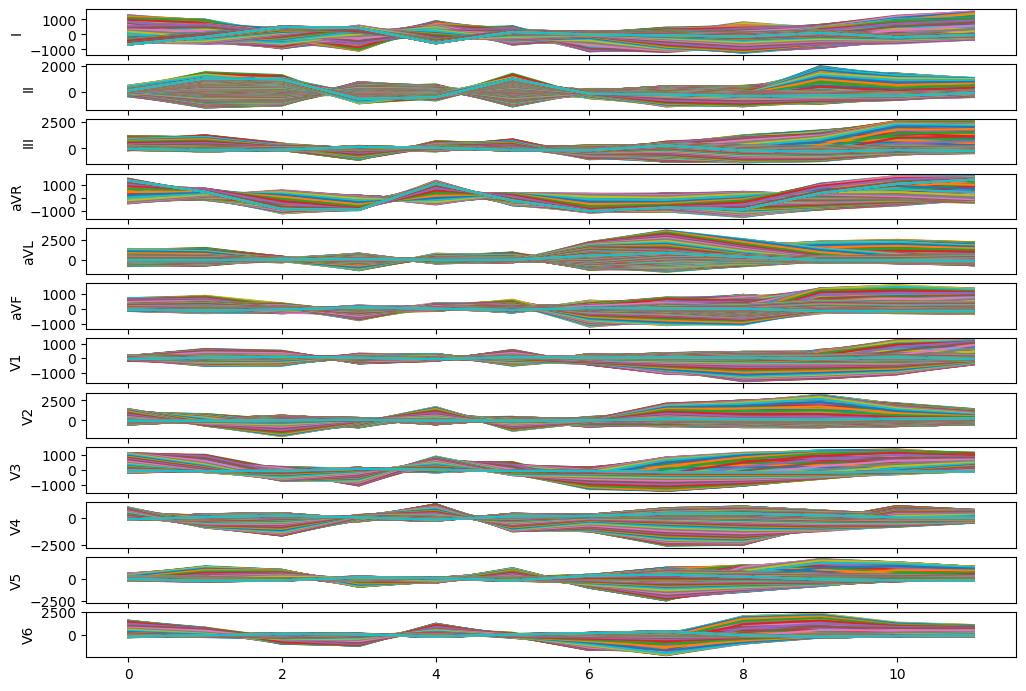

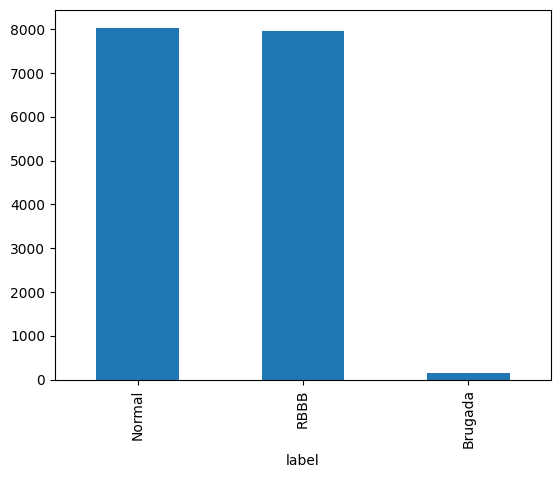

In [12]:
# now we can use the ChinaDataset class to load the data
from China_Dataset import ChinaDataset
import data_visualisation as dv
import data_augmentation as da
import random


root_dir = 'DAT China'
china_dataset = ChinaDataset(root_dir=root_dir, split='train', test_size=0.2, random_state=42)

print(len(china_dataset))

random_item, random_label = china_dataset[random.randint(0, len(china_dataset))]
print(random_label)

# plot the ecg
dv.plot_12_lead_ecg(ecg)

# get label distribution
label_distribution = china_dataset.annotations['label'].value_counts()
plot = label_distribution.plot(kind='bar')

# get a brugada sample
brugada_sample, brugada_label = china_dataset[0]